# Project 1
**Alexander Laloi Dybdahl, Viktor Ellevseth**

In [53]:
# %load_ext autoreload
%autoreload 2
import numpy as np

from helpers import *
from plots import *
from cross_validation import *
from build_polynomial import *
from validation import *
from preproccessing import *
from implementations import *

from gradient_descent import *
from stochastic_gradient_descent import *
from least_squares import *
from ridge_regression import *
from logistic_regression import *

#### Load data

In [9]:
x_train, x_test, y_train, train_ids, test_ids = load_csv_data("data/", sub_sample=False)

In [10]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)

(328135, 321)
(328135,)
(109379, 321)


## Run

In [126]:
# Define constants
names = ["Least Squares", "Gradient Descent", "Stochastic Gradient Descent", "Ridge Regression", "Logistic Regression", "Regularized Logistic Regression"]
max_iters = 1000
seed = 123

# Define hyperparameters
gamma = 0.1
lambda_ridge = 0.01
lambda_logistic = 0.001

# Preprocess data
tx_train, tx_validate, tx_test, y, y_validate = preprocess_data(
                                       x_train[:, 9:],
                                       x_test[:, 9:],
                                       y_train,
                                       min_unique = 7,
                                       var_tol = 0.0001,
                                       corr_tol = 0.999,
                                       empty_tol = 0.90,
                                       num_components = 300,
                                       validation_size = 0.10,
                                       ratio = 0.10,
                                       seed = 1,
                                       pca = False,
                                       hon = True
)

# Define initial w
np.random.seed(seed)
initial_w = np.random.random(tx_train.shape[1])

print(tx_train.shape, tx_test.shape, tx_validate.shape)

encoding (328135, 930) (109379, 930)
imputing (328135, 930) (109379, 930)
removing low var (328135, 756) (109379, 756)
removing high corr (328135, 673) (109379, 673)
standardize (328135, 673) (109379, 673)
splitting (295322, 673) (109379, 673) (32813, 673)
balancing (469656, 673) (109379, 673) (32813, 673)
(469656, 673) (109379, 673) (32813, 673)


In [127]:
print(len(y[y == 1])/len(y))

0.5


## Train 

In [128]:
mses = []
ws = []

In [129]:
w_ls, mse_ls = least_squares(y, tx_train)
print(mse_ls)
mses.append(mse_ls)
ws.append(w_ls)

0.07527283834546933


In [130]:
w_gd, mse_gd = mean_squared_error_gd(y, tx_train, w_ls, max_iters=max_iters, gamma=gamma)
print(mse_gd)
mses.append(mse_gd)
ws.append(w_gd)

Current iteration=0, loss=0.07527283834540165
Gradient close to zero
0.07527283834540165


In [131]:
w_sgd, mse_sgd = mean_squared_error_sgd(y, tx_train, w_ls, max_iters=max_iters, gamma=gamma, batch_size=y.shape[0])
print(mse_sgd)
mses.append(mse_sgd)
ws.append(w_sgd)

Current iteration=0, loss=0.07527283834540165
Gradient close to zero
0.07527283834540165


In [132]:
w_rr, mse_rr = ridge_regression(y, tx_train, lambda_ridge)
print(mse_rr)
mses.append(mse_rr)
ws.append(w_rr)

0.12011036419319258


In [133]:
np.random.seed(seed)
initial_w = np.zeros(tx_train.shape[1])

w_lr, mse_lr = logistic_regression(y, tx_train, initial_w, max_iters=1000, gamma=0.1, seed=seed)
print(mse_lr)
mses.append(mse_lr)
ws.append(w_lr)

Current iteration=0, loss=0.5696675173014216
Current iteration=100, loss=0.5105792074730767
Current iteration=200, loss=0.5089309845437658
Current iteration=300, loss=0.5080425889588881
Current iteration=400, loss=0.5074158513955448
Current iteration=500, loss=0.5069105353633221


In [ ]:
w_rlr, mse_rlr = reg_logistic_regression(y, tx_train, lambda_logistic, w_lr, max_iters=1000, gamma=0.1, seed=seed)
print(mse_rlr)
mses.append(mse_rlr)
ws.append(w_rlr)

Current iteration=0, loss=0.4506835199210324
Current iteration=100, loss=0.45065142773159556
Current iteration=200, loss=0.4506221913442393
Current iteration=300, loss=0.4505958913592333
Current iteration=400, loss=0.45057242519447066
Current iteration=500, loss=0.45055150246995274
Current iteration=600, loss=0.450532815680633
Current iteration=700, loss=0.4505160829629993
Current iteration=800, loss=0.4505010566063722
Current iteration=900, loss=0.45048752211120885
Reached max iterations
0.07301487144373624


In [ ]:
print_mse(names, mses)

Method                                    MSE Value      
---------------------------------------------------------
Least Squares                            0.2003294443
Gradient Descent                         0.2003294443
Stochastic Gradient Descent              0.2003294443
Ridge Regression                         0.2005085527
Logistic Regression                      0.0730458721
Regularized Logistic Regression          0.0730148714


## Test methods

### Testing on validation set

In [ ]:
# Cutoff values for regression and classification methods
cutoffs = np.linspace(0.10, 0.99, 51)
cutoff_ls, f1_scores_ls = cross_validation_cutoffs(y_validate, tx_validate, w_ls, predict_class, cutoffs, plot=False) # 0.66
cutoff_rr, f1_scores_rr = cross_validation_cutoffs(y_validate, tx_validate, w_rr, predict_class, cutoffs, plot=False) # 0.62
cutoff_lr, f1_scores_lr = cross_validation_cutoffs(y_validate, tx_validate, w_lr, predict_class, cutoffs, plot=False) # 0.81
cutoff_rlr, f1_scores_rlr = cross_validation_cutoffs(y_validate, tx_validate, w_rlr, predict_class, cutoffs, plot=False) # 0.69

In [ ]:
print("cutoffs", cutoff_ls, cutoff_rr, cutoff_lr, cutoff_rlr)

# Predict for regression methods
pred_ls = predict_reg(tx_validate, w_ls, cutoff_ls)
pred_gd = predict_reg(tx_validate, w_gd, cutoff_ls)
pred_sgd = predict_reg(tx_validate, w_sgd, cutoff_ls)
pred_rr = predict_reg(tx_validate, w_rr, cutoff_rr)

# Predict for classification methods
pred_lr = predict_class(tx_validate, w_lr, cutoff_lr)
pred_rlr = predict_class(tx_validate, w_rlr, cutoff_rlr)

predictions = [pred_ls, pred_gd, pred_sgd, pred_rr, pred_lr, pred_rlr]

plot_results(y_validate, predictions, names)

cutoffs 0.723 0.5806 0.8832 0.8832
Method                                                     Accuracy   F1 Score   Type II Error  
------------------------------------------------------------------------------------------------
Least Squares                                                0.596      0.190      0.462
Gradient Descent                                             0.596      0.190      0.462
Stochastic Gradient Descent                                  0.596      0.190      0.462
Ridge Regression                                             0.915      0.315      0.777
Logistic Regression                                          0.870      0.428      0.446
Regularized Logistic Regression                              0.871      0.428      0.448


In [ ]:
for name, pred in zip(names, predictions):
    print(name)
    print(confusion_matrix(y_validate, pred))
    print()

Least Squares
[[ 1538 11726]
 [ 1345 18204]]

Gradient Descent
[[ 1538 11726]
 [ 1345 18204]]

Stochastic Gradient Descent
[[ 1538 11726]
 [ 1345 18204]]

Ridge Regression
[[  642   547]
 [ 2241 29383]]

Logistic Regression
[[ 1597  2981]
 [ 1286 26949]]

Regularized Logistic Regression
[[ 1591  2956]
 [ 1292 26974]]



In [ ]:
# Calculate classification
pred = np.where(tx_test @ w_ls > cutoff_ls, 1, -1)
print(len(pred[pred == 1])/len(pred))
create_csv_submission(test_ids, pred, "data/sample_submission_ls.csv")

# Calculate classification
pred = np.where(tx_test @ w_rr > cutoff_rr, 1, -1)
print(len(pred[pred == 1])/len(pred))
create_csv_submission(test_ids, pred, "data/sample_submission_ridge.csv")

# Calculate classification
pred = np.where(sigmoid(tx_test @ w_lr) > cutoff_lr, 1, -1)
print(len(pred[pred == 1])/len(pred))
create_csv_submission(test_ids, pred, "data/sample_submission_lr.csv")

# Calculate classification
pred = np.where(sigmoid(tx_test @ w_rlr) > cutoff_rlr, 1, -1)
print(len(pred[pred == 1])/len(pred))
create_csv_submission(test_ids, pred, "data/sample_submission_rlr.csv")

0.3982300075882939
0.03495186461752256
0.14012744676766106
0.13913091178379763


## Cross Validation on lambda and cutoffs on Ridge Regression

In [ ]:
lambdas = np.logspace(-4, 0, 30)
k_fold = 7

best_lambda_ridge, best_rmse = cross_validation_lambda(y, tx_train, ridge_regression, k_fold, lambdas, seed=seed, args=())
print("Best lambda:", best_lambda_ridge)
print("Best rmse:", best_rmse)

lambda 0.0001
lambda 0.00013738237958832623
lambda 0.00018873918221350977
lambda 0.0002592943797404667
lambda 0.0003562247890262444


KeyboardInterrupt: 

In [ ]:
cutoffs_rr_CV = np.linspace(0.1, 0.9, 50)
best_cutoff_rr, f1_scores_rr_CV = cross_validation_cutoffs(y_validate, tx_validate, w_rr, predict_class, cutoffs_rr_CV, plot=False)
print(best_cutoff_rr)

0.6224489795918368


In [ ]:
w_rr_CV, mse_rr_CV = ridge_regression(y, tx_train, best_lambda_ridge)
print(mse_rr_CV)

pred_rr_poly = predict_reg(tx_validate, w_rr_CV, best_cutoff_rr)
predictions.append(pred_rr_poly)
names.append("Ridge Regression CV ")
plot_results(y_validate, predictions, names)

0.12344696064996927
Method                                                     Accuracy   F1 Score   Type II Error  
------------------------------------------------------------------------------------------------
Least Squares                                                0.493      0.160      0.451
Gradient Descent                                             0.493      0.160      0.451
Stochastic Gradient Descent                                  0.493      0.160      0.451
Ridge Regression                                             0.902      0.393      0.637
Logistic Regression                                          0.862      0.412      0.447
Regularized Logistic Regression                              0.832      0.406      0.348
Ridge Regression CV                                          0.902      0.392      0.642


In [ ]:
# Calculate classification
pred = np.where(tx_test @ w_rr_CV > cutoff_rr, 1, -1)
print(len(pred[pred == 1])/len(pred))

# Write classifications to file
create_csv_submission(test_ids, pred, "data/sample_submission_ridge_CV.csv")

0.07498697190502747


## Cross Validation on lambda and cutoffs on RLR

In [ ]:
lambdas = [0.001, 0.005, 0.01, 0.05, 0.1]
k_fold = 5

best_lambda_rlr, best_rmse = cross_validation_lambda(y, tx_train, reg_logistic_regression, k_fold, lambdas, seed=seed, loss_type="class", args=(w_lr, ))
print("Best lambda:", best_lambda_rlr)
print("Best rmse:", best_rmse)

lambda 1e-05
Current iteration=0, loss=0.5104649078243285
Current iteration=100, loss=0.5037828548340212
Current iteration=200, loss=0.5014720611472897
Current iteration=300, loss=0.5000433319870683
Current iteration=400, loss=0.499965645847967
Current iteration=500, loss=0.5009719957422993
Current iteration=600, loss=0.5030207019889337
Current iteration=700, loss=0.5059822556810365
Current iteration=800, loss=0.5097017440818468
Current iteration=900, loss=0.5140282182069179
Reached max iterations
Current iteration=0, loss=0.506620963472934
Current iteration=100, loss=0.5015808806030008
Current iteration=200, loss=0.500324614369765
Current iteration=300, loss=0.49910628681391744
Current iteration=400, loss=0.4992299862805157
Current iteration=500, loss=0.5004582412889805
Current iteration=600, loss=0.5027521358092272
Current iteration=700, loss=0.5059786220658443
Current iteration=800, loss=0.5099792627637476
Current iteration=900, loss=0.5145999100664063
Reached max iterations
Current

KeyboardInterrupt: 

In [ ]:
cutoffs_rlr_CV = np.linspace(0.1, 0.99, 55)
best_cutoff_rlr, f1_scores_rlr_CV = cross_validation_cutoffs(y_validate, tx_validate, w_rlr, predict_class, cutoffs_rlr_CV, plot=False)
print(best_cutoff_rlr)

0.7262962962962963


In [ ]:
w_rlr_CV, mse_rlr_CV = reg_logistic_regression(y, tx_train, 0.1, w_rlr)
print(mse_rlr_CV)

pred_rlr_poly = predict_reg(tx_validate, w_rlr_CV, best_cutoff_rlr)
predictions.append(pred_rlr_poly)
names.append("Regularized Logistic Regression CV ")
plot_results(y_validate, predictions, names)

Current iteration=0, loss=0.5246587466120257
Current iteration=100, loss=0.5150223383963726
Current iteration=200, loss=0.5182493398212649
Current iteration=300, loss=0.5180214132994074
Current iteration=400, loss=0.519589109087956
Gradient close to zero
0.0856070690838997
Method                                                     Accuracy   F1 Score   Type II Error  
------------------------------------------------------------------------------------------------
Least Squares                                                0.493      0.160      0.451
Gradient Descent                                             0.493      0.160      0.451
Stochastic Gradient Descent                                  0.493      0.160      0.451
Ridge Regression                                             0.902      0.393      0.637
Logistic Regression                                          0.862      0.412      0.447
Regularized Logistic Regression                              0.832      0.406      0.34

In [ ]:

# Calculate classification
pred = np.where(sigmoid(tx_test @ w_rlr) > cutoff_rlr, 1, -1)
print(len(pred[pred == 1])/len(pred))

# Write classifications to file
create_csv_submission(test_ids, pred, "data/sample_submission_rlr.csv")

0.21622066393000486


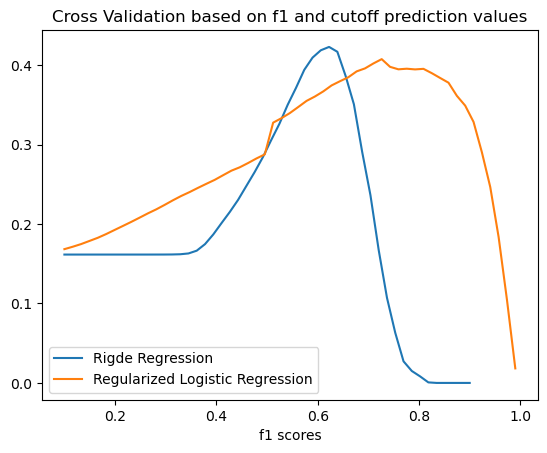

In [ ]:
plt.plot(cutoffs_rr_CV, f1_scores_rr_CV, label="Rigde Regression")
plt.plot(cutoffs_rlr_CV, f1_scores_rlr_CV, label="Regularized Logistic Regression")
plt.legend()
plt.title("Cross Validation based on f1 and cutoff prediction values")
plt.xlabel("cutoffs")
plt.xlabel("f1 scores")
plt.savefig("cross_validation_rr_and_rlr")

## Polynomial regression

In [ ]:
degree = 2
tx_poly = build_poly_multivariate(tx_train, degree)
tx_validate_poly = build_poly_multivariate(tx_validate, degree)
tx_test_poly = build_poly_multivariate(tx_test, degree)

np.random.seed(seed)
initial_w = np.random.random(tx_poly.shape[1])

In [ ]:
w_ls_poly, mse_ls_poly = least_squares(y, tx_poly)
print(mse_ls_poly)

pred_rr_poly = predict_reg(tx_validate_poly, w_ls_poly)
predictions.append(pred_rr_poly)
names.append("Least Squares Poly " + str(degree))
plot_results(y_validate, predictions, names)

0.07692537592223618
Method                                                     Accuracy   F1 Score   Type II Error  
------------------------------------------------------------------------------------------------
Least Squares                                                0.493      0.160      0.451
Gradient Descent                                             0.493      0.160      0.451
Stochastic Gradient Descent                                  0.493      0.160      0.451
Ridge Regression                                             0.902      0.393      0.637
Logistic Regression                                          0.862      0.412      0.447
Regularized Logistic Regression                              0.832      0.406      0.348
Ridge Regression CV                                          0.902      0.392      0.642
Least Squares Poly 2                                         0.536      0.181      0.418


In [ ]:
w_rr_poly, mse_rr_poly = ridge_regression(y, tx_poly, best_lambda_ridge)
print(mse_rr_poly)

pred_rr_poly = predict_reg(tx_validate_poly, w_rr_poly)
predictions.append(pred_rr_poly)
names.append("Ridge Regression Poly " + str(degree))
plot_results(y_validate, predictions, names)

0.07693354893762133
Method                                                     Accuracy   F1 Score   Type II Error  
------------------------------------------------------------------------------------------------
Least Squares                                                0.493      0.160      0.451
Gradient Descent                                             0.493      0.160      0.451
Stochastic Gradient Descent                                  0.493      0.160      0.451
Ridge Regression                                             0.902      0.393      0.637
Logistic Regression                                          0.862      0.412      0.447
Regularized Logistic Regression                              0.832      0.406      0.348
Ridge Regression CV                                          0.902      0.392      0.642
Least Squares Poly 2                                         0.536      0.181      0.418
Ridge Regression Poly 2                                      0.763      0.

In [ ]:
w_rlr_poly, mse_rlr_poly = reg_logistic_regression(y, tx_poly, lambda_logistic, initial_w, max_iters, gamma=gamma)
print(mse_rlr_poly)

pred_rlr_poly = predict_class(tx_validate_poly, w_rlr_poly)
predictions.append(pred_rlr_poly)
names.append("Regularized Logistic Regression Poly " + str(degree) + " Lambda " + str(lambda_logistic))
plot_results(y_validate, predictions, names)

Current iteration=0, loss=0.8143905987955656
Current iteration=100, loss=0.9674856780836784
Current iteration=200, loss=0.8160487672063753
Current iteration=300, loss=0.7557373377709026
Current iteration=400, loss=0.7182980269712284
Current iteration=500, loss=0.7123115860769277
Current iteration=600, loss=0.6930781877706963
Current iteration=700, loss=0.6897779720113523
Current iteration=800, loss=0.6858182679596985
Current iteration=900, loss=0.6821037901102738
Reached max iterations
0.11276225985522575
Method                                                     Accuracy   F1 Score   Type II Error  
------------------------------------------------------------------------------------------------
Least Squares                                                0.493      0.160      0.451
Gradient Descent                                             0.493      0.160      0.451
Stochastic Gradient Descent                                  0.493      0.160      0.451
Ridge Regression            